In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn import datasets, manifold





In [2]:
sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

array([[ -8.85708287,   9.38265973,  -4.38885338],
       [  5.0569229 ,  17.57679767, -10.2760021 ],
       [ -5.88799247,   4.65830464,  -8.56459157],
       ...,
       [  5.02792391,   6.7958879 ,  -2.831356  ],
       [  1.98714514,  17.08444537,  -4.70959971],
       [  5.75356613,  14.64540795,   3.73357428]])

In [2]:
print(sr_points.shape[0], sr_color.shape[0])

1500 1500


In [3]:
dist = np.square(euclidean_distances(sr_points, sr_points))
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]

In [4]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[dist_row] - rho[dist_row]; d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

In [5]:
def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0; sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

In [6]:
n =sr_points.shape[0]
N_NEIGHBOR = 15
prob = np.zeros((n,n)); sigma_array = []

for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

C:\Users\msi\AppData\Local\Temp\ipykernel_11272\475420790.py:13: RuntimeWarning: overflow encountered in power
  return np.power(2, np.sum(prob))


Sigma binary search finished 100 of 1500 cells
Sigma binary search finished 200 of 1500 cells
Sigma binary search finished 300 of 1500 cells
Sigma binary search finished 400 of 1500 cells
Sigma binary search finished 500 of 1500 cells
Sigma binary search finished 600 of 1500 cells
Sigma binary search finished 700 of 1500 cells
Sigma binary search finished 800 of 1500 cells
Sigma binary search finished 900 of 1500 cells
Sigma binary search finished 1000 of 1500 cells
Sigma binary search finished 1100 of 1500 cells
Sigma binary search finished 1200 of 1500 cells
Sigma binary search finished 1300 of 1500 cells
Sigma binary search finished 1400 of 1500 cells
Sigma binary search finished 1500 of 1500 cells

Mean sigma = 0.9287904103597006


In [7]:
P = (prob + np.transpose(prob)) / 2
P

array([[1.00000000e+000, 2.00529686e-165, 8.60712468e-019, ...,
        4.59376053e-096, 2.22167865e-128, 1.99253145e-180],
       [2.00529686e-165, 1.00000000e+000, 1.97023250e-109, ...,
        8.16731355e-082, 1.99032762e-023, 3.15135515e-115],
       [8.60712468e-019, 1.97023250e-109, 1.00000000e+000, ...,
        2.05446418e-059, 1.68039816e-087, 7.13984215e-146],
       ...,
       [4.59376053e-096, 8.16731355e-082, 2.05446418e-059, ...,
        1.00000000e+000, 7.62623289e-057, 1.53985370e-050],
       [2.22167865e-128, 1.99032762e-023, 1.68039816e-087, ...,
        7.62623289e-057, 1.00000000e+000, 5.37111462e-054],
       [1.99253145e-180, 3.15135515e-115, 7.13984215e-146, ...,
        1.53985370e-050, 5.37111462e-054, 1.00000000e+000]])

In [8]:
from scipy import optimize 
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.1214363425627392 and b = 1.0574998764478827


In [9]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [10]:
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact=np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

Running Gradient Descent: 

Cross-Entropy = 102.4963228186697 after 0 iterations
Cross-Entropy = 4.075934995596815 after 10 iterations
Cross-Entropy = 1.9761171715699106 after 20 iterations
Cross-Entropy = 1.3878939686221619 after 30 iterations
Cross-Entropy = 1.0576375965341072 after 40 iterations
Cross-Entropy = 0.8548558603711198 after 50 iterations
Cross-Entropy = 0.7122053147926295 after 60 iterations
Cross-Entropy = 0.6144298161725527 after 70 iterations
Cross-Entropy = 0.5538019819104456 after 80 iterations
Cross-Entropy = 0.5081323570571374 after 90 iterations
Cross-Entropy = 0.45193271790977624 after 100 iterations
Cross-Entropy = 0.43229480706572243 after 110 iterations
Cross-Entropy = 0.3962847034142679 after 120 iterations
Cross-Entropy = 0.38408363053607075 after 130 iterations
Cross-Entropy = 0.3600956506249752 after 140 iterations
Cross-Entropy = 0.3507113411468724 after 150 iterations
Cross-Entropy = 0.3389644358256928 after 160 iterations
Cross-Entropy = 0.324311965252

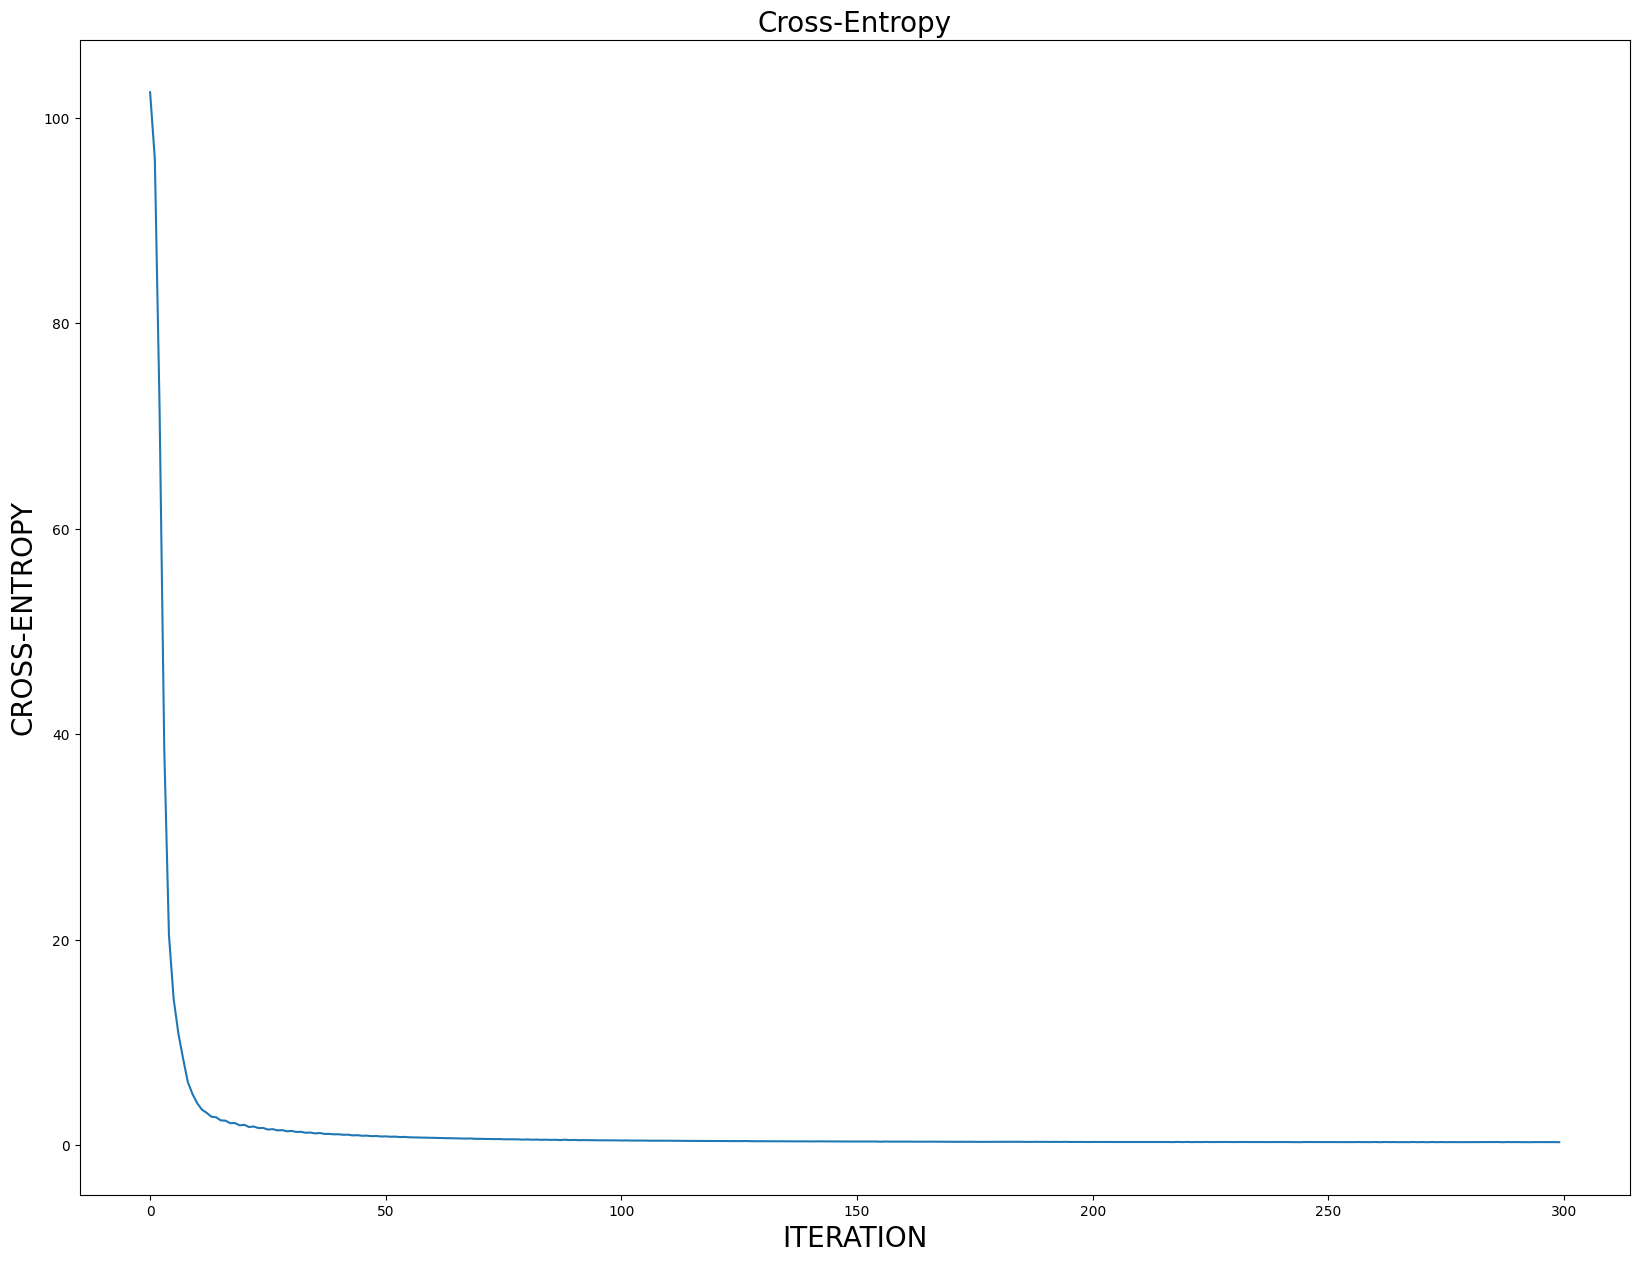

In [23]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 300
from sklearn.manifold import SpectralEmbedding
np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 10)

y = model.fit_transform(sr_points)
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1])
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", 
              fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    #plt.savefig('UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

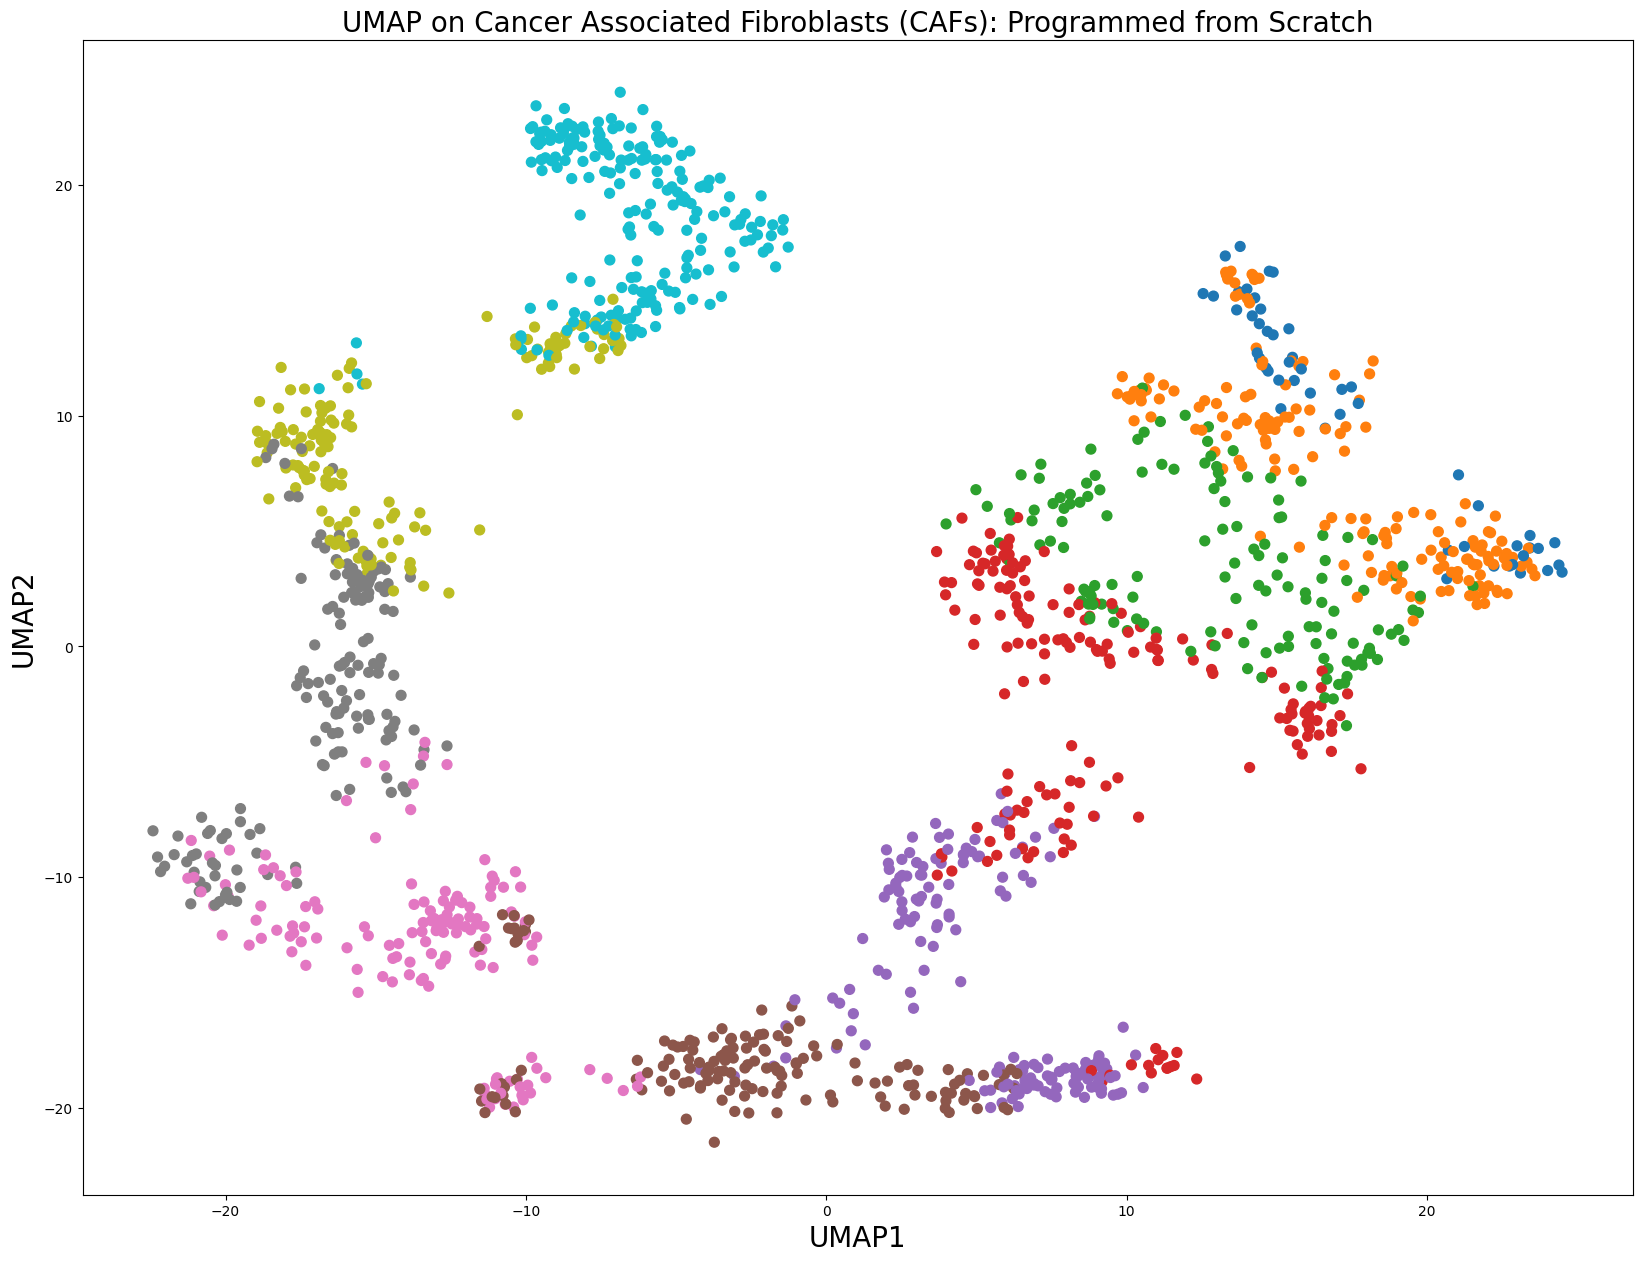

In [24]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1],  c = sr_color.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", 
          fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

In [17]:
pip install umap-learn

  Using cached umap_learn-0.5.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


UMAP(min_dist=0.25, verbose=True)
Tue Oct 10 11:28:11 2023 Construct fuzzy simplicial set
Tue Oct 10 11:28:12 2023 Finding Nearest Neighbors
Tue Oct 10 11:28:12 2023 Finished Nearest Neighbor Search
Tue Oct 10 11:28:12 2023 Construct embedding


Epochs completed:  10%| █          52/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  32%| ███▏       158/500 [00:01]

	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  51%| █████      254/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  69%| ██████▉    346/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed:  88%| ████████▊  442/500 [00:02]

	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Oct 10 11:28:15 2023 Finished embedding


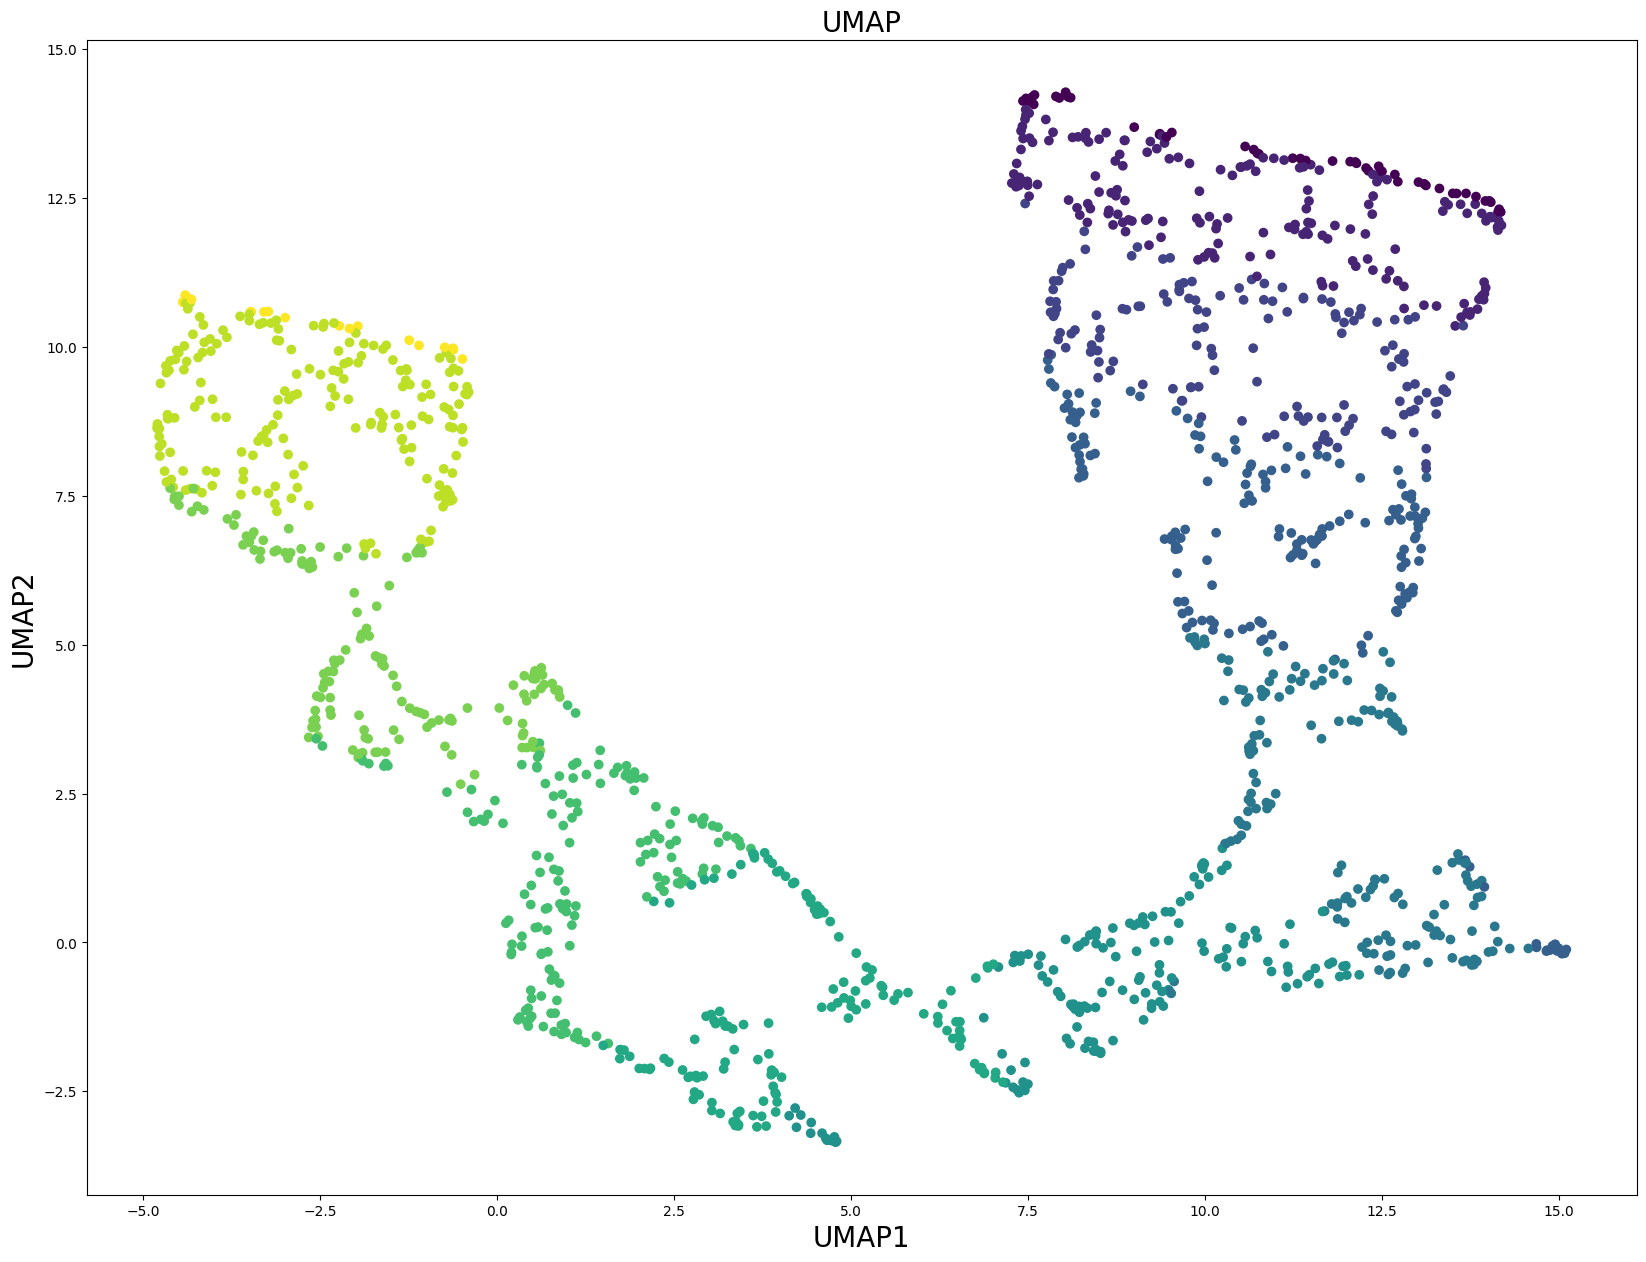

In [26]:
from umap import UMAP
plt.figure(figsize=(20,15))
reducer = UMAP(n_neighbors=50, n_components=2, metric='euclidean')
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(sr_points)
plt.scatter(umap[:, 0], umap[:, 1], c = sr_color.astype(int))
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

In [19]:
from umap import UMAP